In [1]:
import pandas as pd
import numpy as np
import scipy.io
import tensorflow as tf

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.stats import norm
import statistics

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
mat = scipy.io.loadmat('/content/MackeyGlass.mat')

In [3]:
X = pd.DataFrame(mat["mackeyglass_input"])
y = pd.DataFrame(mat["mackeyglass_target"])

In [4]:
df = pd.concat([X, y], axis=1)
df.columns=['F1', 'F2', 'F3', 'F4', 'Class']
df

,F1,F2,F3,F4,Class
0,1.068370,1.17901,1.25697,1.137430,1.17921
1,1.098640,1.18587,1.27054,1.083680,1.19920
2,1.123700,1.19331,1.27180,1.028270,1.21819
3,1.143780,1.20366,1.25741,0.973285,1.23632
4,1.159230,1.21854,1.22801,0.920146,1.25366
...,...,...,...,...,...
3495,0.945730,1.13482,1.18397,1.247010,1.16554
3496,0.992825,1.14317,1.20329,1.217760,1.18095
3497,1.035480,1.14836,1.22510,1.176230,1.19638
3498,1.071770,1.15288,1.24550,1.126980,1.21277


# NN

Without fuzzy

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from sklearn.metrics import accuracy_score

In [6]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# y_encoded = pd.get_dummies(y_train)

In [ ]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 50)

# fit network
history = model.fit(X_train, y_train, epochs=100, validation_split = 0.2, verbose=2, callbacks = [early_stopping_callback])

Epoch 1/100
70/70 - 1s - loss: 0.1109 - val_loss: 0.0176
Epoch 2/100
70/70 - 0s - loss: 0.0161 - val_loss: 0.0139
Epoch 3/100
70/70 - 0s - loss: 0.0153 - val_loss: 0.0132
Epoch 4/100
70/70 - 0s - loss: 0.0152 - val_loss: 0.0131
Epoch 5/100
70/70 - 0s - loss: 0.0151 - val_loss: 0.0131
Epoch 6/100
70/70 - 0s - loss: 0.0151 - val_loss: 0.0133
Epoch 7/100
70/70 - 0s - loss: 0.0151 - val_loss: 0.0129
Epoch 8/100
70/70 - 0s - loss: 0.0151 - val_loss: 0.0132
Epoch 9/100
70/70 - 0s - loss: 0.0153 - val_loss: 0.0130
Epoch 10/100
70/70 - 0s - loss: 0.0150 - val_loss: 0.0144
Epoch 11/100
70/70 - 0s - loss: 0.0153 - val_loss: 0.0128
Epoch 12/100
70/70 - 0s - loss: 0.0149 - val_loss: 0.0127
Epoch 13/100
70/70 - 0s - loss: 0.0149 - val_loss: 0.0132
Epoch 14/100
70/70 - 0s - loss: 0.0153 - val_loss: 0.0127
Epoch 15/100
70/70 - 0s - loss: 0.0151 - val_loss: 0.0131
Epoch 16/100
70/70 - 0s - loss: 0.0150 - val_loss: 0.0130
Epoch 17/100
70/70 - 0s - loss: 0.0149 - val_loss: 0.0124
Epoch 18/100
70/70 - 0s

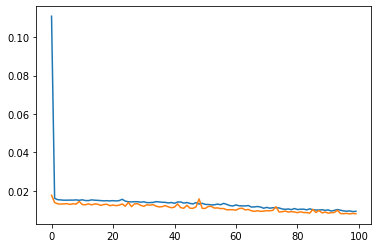

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
len(np.squeeze(y_pred))

700

In [ ]:
pd.DataFrame({"Actual" : np.squeeze(y_test.values), 
              "Predicted" : np.squeeze(y_pred)})

,Actual,Predicted
0,1.075260,1.040365
1,1.040830,1.050200
2,0.517414,0.666760
3,1.050910,0.974347
4,1.138640,1.106736
...,...,...
695,0.553689,0.558316
696,1.040520,0.942907
697,0.565832,0.596594
698,1.131550,1.116540


In [ ]:
mean_squared_error(y_test, y_pred)

0.00885936356407511

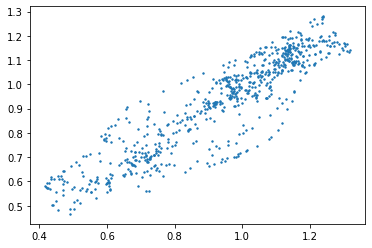

In [ ]:
plt.scatter(y_test, y_pred, s=2)

# Layer 1: Creating Memberships

In [ ]:
# Functions to get the gaussian projections of all clusters on one specific axis

# Gets the datapoints and centroid coordinates for a particular cluster
def get_data_centroid(X, y_pred, cluster_label):
    datapoints = X[y_pred==cluster_label,:]
    centroid_coord = np.mean(datapoints, axis=0) 
    return datapoints, centroid_coord

# Gets the mean and std of a particular cluster (for 1 dimension only)
def mean_std(cluster_data, dim):
    points = cluster_data[:,dim]
    return statistics.mean(points), statistics.stdev(points)

# Gets the data required for each dimension (for all clusters)
def get_dimension_dict(X, num_clusters, dim, y_pred):
    dim_dict = {}
    
    for i in range(num_clusters):
        dim_dict["cluster"+str(i)] = {}
        data, centroid = get_data_centroid(X, y_pred, i)
        data_mean, data_std = mean_std(data, dim)
        dim_dict["cluster"+str(i)]["data"] = data
        dim_dict["cluster"+str(i)]["centroid"] = centroid
        dim_dict["cluster"+str(i)]["mean"] = data_mean
        dim_dict["cluster"+str(i)]["std"] = data_std
        
    return dim_dict

# Plot the gaussian projections of each cluster on the specified dimension
def plot_projection(dim_dict, num_clusters, title):
    
    plt.subplot(1,1,1)
    plt.title(title)
    for i in range(num_clusters):
        mean = dim_dict["cluster"+str(i)]["mean"]
        std = dim_dict["cluster"+str(i)]["std"]
        x = np.linspace(mean - 6*std, mean+6*std, 100)
        y = norm.pdf(x, mean, std)
        plt.plot(x, y/max(y), label="Cluster #"+str(i))
        
    plt.legend(bbox_to_anchor=(1.35, 0.7))

In [ ]:
def dimension_projection(data, y_pred, title, dim):
  num_outliers = (np.sum(np.array(y_pred) == -1, axis=0))
  num_clusters = (len(set(y_pred)) - (1 if -1 in y_pred else 0))
  print('Number of noise points: ', num_outliers)
  print("Number of clusters: ", num_clusters)

  unique = pd.DataFrame(np.unique(y_pred, return_counts = True))
  print("Unqiue Clusters: ")
  display(unique)

  print("Centroids: ")
  for i in range(num_clusters):
      print("centroid", str(i), ": ", get_data_centroid(data, y_pred, i)[1])
      
  dim_dict = get_dimension_dict(data, num_clusters, dim, y_pred)
  plot_projection(dim_dict, num_clusters, title)

  return num_clusters, dim_dict

In [ ]:
def output_fuzzy_memberships(dim_dict, num_clusters, dim_data_pt):
    fuzzy_memberships = []
    for i in range(num_clusters):
        mean = dim_dict["cluster"+str(i)]["mean"]
        std = dim_dict["cluster"+str(i)]["std"]
        pdf = norm(mean, std).pdf(dim_data_pt)
        max_y = norm(mean, std).pdf(mean)
        fuzzy_memberships.append(pdf/max_y)
      
    # max_membership = max(fuzzy_memberships)
    # index = fuzzy_memberships.index(max_membership)
    return fuzzy_memberships

In [ ]:
index = 0
data1 = df.iloc[index, :-1]
data1

F1    5.1
F2    3.5
F3    1.4
F4    0.2
Name: 0, dtype: float64

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# y_encoded = pd.get_dummies(y_train)

# F1 DBSCAN

In [ ]:
F1 = df[['F1']].values

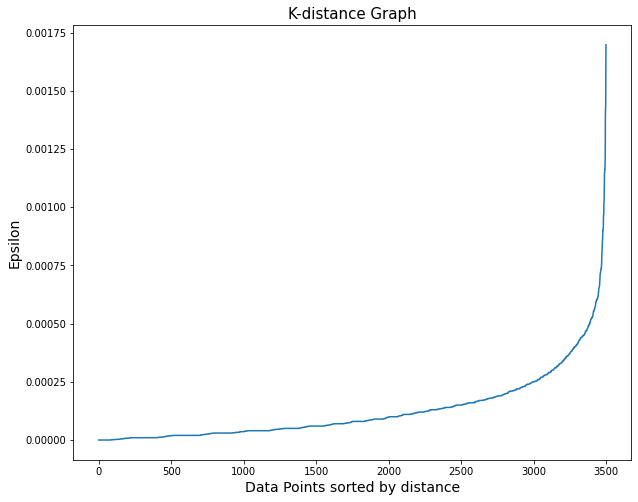

In [ ]:
# To help find the value of epsilon

neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(F1)
distances, indices = nbrs.kneighbors(F1)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=15)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

(array([0.53276328, 0.5708178 , 0.89745242, 1.17969011, 0.89428121,
        1.11943712, 1.75685033, 1.93126688, 1.50315353, 0.71352225]),
 array([0.418027 , 0.5081233, 0.5982196, 0.6883159, 0.7784122, 0.8685085,
        0.9586048, 1.0487011, 1.1387974, 1.2288937, 1.31899  ]),
 <a list of 10 Patch objects>)

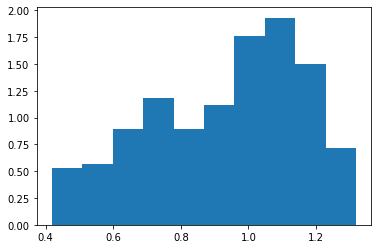

In [ ]:
plt.hist(F1, density=True)

Number of noise points:  27
Number of clusters:  11
Unqiue Clusters: 


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1,0,1,2,3,4,5,6,7,8,9,10
1,27,2944,220,42,96,59,32,28,18,13,14,7


Centroids: 
centroid 0 :  [0.99753396]
centroid 1 :  [0.62725745]
centroid 2 :  [0.57738371]
centroid 3 :  [0.53636986]
centroid 4 :  [0.49830654]
centroid 5 :  [0.46816128]
centroid 6 :  [0.43982021]
centroid 7 :  [0.45290511]
centroid 8 :  [0.48147677]
centroid 9 :  [0.42642664]
centroid 10 :  [1.31157571]


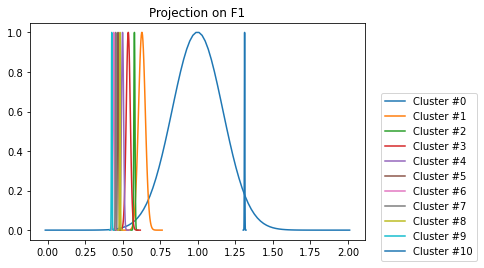

In [ ]:
dbscan = DBSCAN(eps=0.003, min_samples=10).fit(F1)
y_pred = dbscan.labels_

num_clusters, dim_dict = dimension_projection(F1, y_pred, "Projection on F1", 0)

In [ ]:
output_fuzzy_memberships(dim_dict, num_clusters, data1[0])

(0, 0.6739162894232449)

In [ ]:
train_F1_data = list(X_train.iloc[:, 0])
test_F1_data = list(X_test.iloc[:, 0])

train_F1_fuzzified = []
for i in train_F1_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  train_F1_fuzzified.append(fuzzified)

test_F1_fuzzified = []
for i in test_F1_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  test_F1_fuzzified.append(fuzzified)

# F2 DBSCAN

In [ ]:
F2 = df[['F2']].values

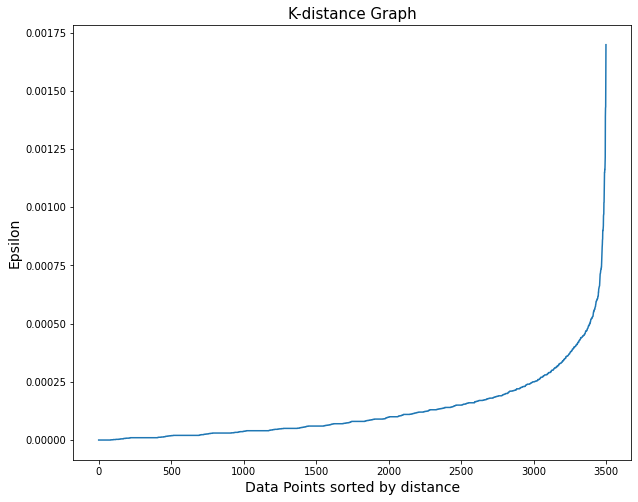

In [ ]:
# To help find the value of epsilon

neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(F2)
distances, indices = nbrs.kneighbors(F2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=15)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Number of noise points:  27
Number of clusters:  11
Unqiue Clusters: 


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1,0,1,2,3,4,5,6,7,8,9,10
1,27,2944,220,42,96,59,32,28,18,13,14,7


Centroids: 
centroid 0 :  [0.99774837]
centroid 1 :  [0.62725745]
centroid 2 :  [0.57738371]
centroid 3 :  [0.53636986]
centroid 4 :  [0.49830654]
centroid 5 :  [0.46816128]
centroid 6 :  [0.43982021]
centroid 7 :  [0.45290511]
centroid 8 :  [0.48147677]
centroid 9 :  [0.42642664]
centroid 10 :  [1.31157571]


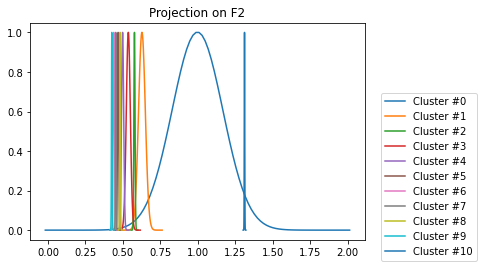

In [ ]:
dbscan = DBSCAN(eps=0.003, min_samples=10).fit(F2)
y_pred = dbscan.labels_

num_clusters, dim_dict = dimension_projection(F2, y_pred, "Projection on F2", 0)

In [ ]:
output_fuzzy_memberships(dim_dict, num_clusters, data1[1])

(0, 0.5970683388109018)

In [ ]:
train_F2_data = list(X_train.iloc[:, 1])
test_F2_data = list(X_test.iloc[:, 1])

train_F2_fuzzified = []
for i in train_F2_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  train_F2_fuzzified.append(fuzzified)

test_F2_fuzzified = []
for i in test_F2_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  test_F2_fuzzified.append(fuzzified)

In [ ]:
test_F2_fuzzified[0:3]

[[0.6970329752678565,
  2.3734124771143434e-114,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.6391725562730888,
  1.107624183370473e-121,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.6850186403052687,
  3.732283666197173e-22,
  0.0,
  1.2422407214811376e-120,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

# F3 DBSCAN

In [ ]:
F3 = df[['F3']].values

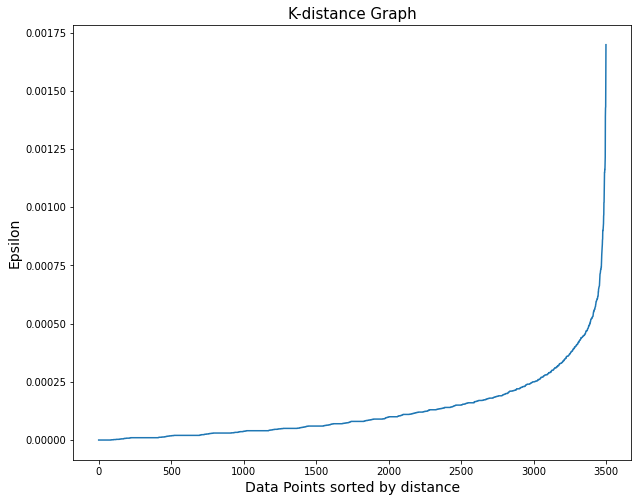

In [ ]:
# To help find the value of epsilon

neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(F3)
distances, indices = nbrs.kneighbors(F3)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=15)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Number of noise points:  27
Number of clusters:  11
Unqiue Clusters: 


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1,0,1,2,3,4,5,6,7,8,9,10
1,27,2944,220,42,96,59,32,28,18,13,14,7


Centroids: 
centroid 0 :  [0.99799869]
centroid 1 :  [0.62725745]
centroid 2 :  [0.57738371]
centroid 3 :  [0.53636986]
centroid 4 :  [0.49830654]
centroid 5 :  [0.46816128]
centroid 6 :  [0.43982021]
centroid 7 :  [0.45290511]
centroid 8 :  [0.48147677]
centroid 9 :  [0.42642664]
centroid 10 :  [1.31157571]


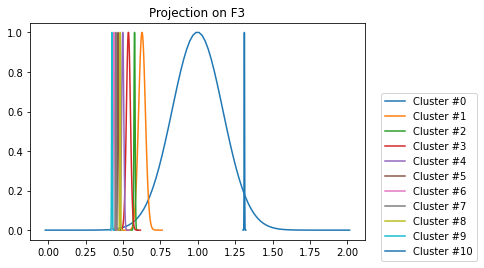

In [ ]:
dbscan = DBSCAN(eps=0.003, min_samples=10).fit(F3)
y_pred = dbscan.labels_

num_clusters, dim_dict = dimension_projection(F3, y_pred, "Projection on F3", 0)

In [ ]:
output_fuzzy_memberships(dim_dict, num_clusters, data1[2])

(0, 0.9382596880501617)

In [ ]:
train_F3_data = list(X_train.iloc[:, 2])
test_F3_data = list(X_test.iloc[:, 2])

train_F3_fuzzified = []
for i in train_F3_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  train_F3_fuzzified.append(fuzzified)

test_F3_fuzzified = []
for i in test_F3_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  test_F3_fuzzified.append(fuzzified)

In [ ]:
test_F3_fuzzified[110]

[0.7056902775813012,
 1.7024044892789046e-113,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

# F4 DBSCAN

In [ ]:
F4 = df[['F4']].values

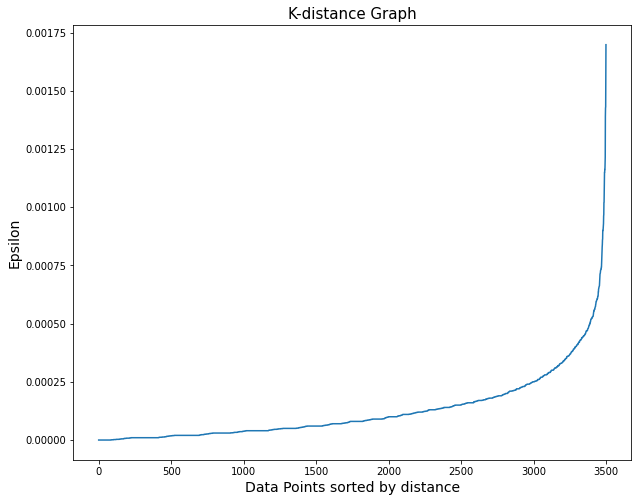

In [ ]:
# To help find the value of epsilon

neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(F4)
distances, indices = nbrs.kneighbors(F4)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=15)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Number of noise points:  27
Number of clusters:  11
Unqiue Clusters: 


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1,0,1,2,3,4,5,6,7,8,9,10
1,27,2944,220,42,96,59,32,28,18,13,14,7


Centroids: 
centroid 0 :  [0.9976476]
centroid 1 :  [0.62725745]
centroid 2 :  [0.57738371]
centroid 3 :  [0.53636986]
centroid 4 :  [0.49830654]
centroid 5 :  [0.46816128]
centroid 6 :  [0.43982021]
centroid 7 :  [0.45290511]
centroid 8 :  [0.48147677]
centroid 9 :  [0.42642664]
centroid 10 :  [1.31157571]


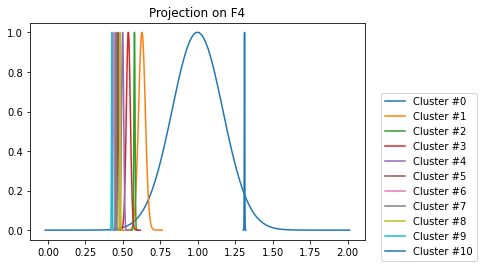

In [ ]:
dbscan = DBSCAN(eps=0.003, min_samples=10).fit(F4)
y_pred = dbscan.labels_

num_clusters, dim_dict = dimension_projection(F4, y_pred, "Projection on F4", 0)

In [ ]:
output_fuzzy_memberships(dim_dict, num_clusters, data1[3])

(0, 0.423403832898659)

In [ ]:
train_F4_data = list(X_train.iloc[:, 3])
test_F4_data = list(X_test.iloc[:, 3])

train_F4_fuzzified = []
for i in train_F4_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  train_F4_fuzzified.append(fuzzified)

test_F4_fuzzified = []
for i in test_F4_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  test_F4_fuzzified.append(fuzzified)

# Layer 2: Fuzzification of inputs

In [ ]:
train_all_fuzzified = []
for i in range(len(train_F1_fuzzified)):
  one_data = []
  one_data.extend(train_F1_fuzzified[i])
  one_data.extend(train_F2_fuzzified[i])
  one_data.extend(train_F3_fuzzified[i])
  one_data.extend(train_F4_fuzzified[i])
  train_all_fuzzified.append(one_data)

test_all_fuzzified = []
for i in range(len(test_F1_fuzzified)):
  one_data = []
  one_data.extend(test_F1_fuzzified[i])
  one_data.extend(test_F2_fuzzified[i])
  one_data.extend(test_F3_fuzzified[i])
  one_data.extend(test_F4_fuzzified[i])
  test_all_fuzzified.append(one_data)

# Layer 3: Into Deep NN

In [ ]:
X_train_fuzzified = pd.DataFrame(train_all_fuzzified)
X_test_fuzzified = pd.DataFrame(test_all_fuzzified)

In [ ]:
X_train_fuzzified

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0.705390,3.946107e-113,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0,0.683475,4.604646e-116,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.620199,2.207892e-124,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.877928,2.150670e-35,0.000000e+00,1.831380e-171,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1,0.548159,2.331881e-133,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0,0.294989,6.535627e-174,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.852371e-226,0.734355,7.387148e-110,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.556311,8.951689e-16,0.000000e+00,1.302425e-94,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.986765,3.478155e-51,0.000000e+00,4.784003e-229,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0,0.277755,5.390590e-05,0.000000e+00,7.896147e-45,6.930460e-222,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.019856,2.284066e-05,1.265646e-43,6.213306e-01,2.246593e-03,5.104210e-48,7.333153e-83,1.058510e-198,3.676354e-80,0.0,0.000000e+00,0.119566,6.288090e-01,7.886072e-76,4.139026e-16,1.060222e-96,0.0,0.0,0.0,0.0,0.0,0.0
3,0.494987,1.136112e-140,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0,0.266391,7.275836e-180,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.781161e-138,0.990911,2.612872e-67,0.000000e+00,7.082145e-286,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.280283,4.561711e-05,0.000000e+00,3.208809e-45,1.609827e-223,0.0,0.0,0.0,0.0,0.0,0.0
4,0.024696,3.598427e-04,8.282698e-24,9.948398e-01,2.652522e-07,6.083674e-76,1.212875e-113,5.564531e-288,2.934034e-144,0.0000,0.0,0.217770,3.790343e-03,7.066660e-230,3.545545e-34,7.519441e-177,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.990301,1.444692e-67,0.000000e+00,9.014666e-287,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.874733,7.887738e-91,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,0.832878,1.202981e-96,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0,0.384065,9.054667e-158,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.167910,6.709284e-206,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,7.080506e-05,0.796279,1.247744e-101,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
2796,0.003182,2.089765e-18,0.000000e+00,5.962010e-16,7.824583e-24,1.779486e-30,1.593863e-03,3.815950e-33,1.908585e-148,0.6766,0.0,0.416390,5.966203e-10,0.000000e+00,3.507988e-69,8.053270e-322,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.985278,7.565779e-51,0.000000e+00,7.713637e-228,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.918225,1.590216e-39,0.000000e+00,8.997544e-187,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
2797,0.839154,8.691595e-96,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0,0.646352,9.101299e-121,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.313792,1.183745e-170,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.448248e-284,0.892817,4.158343e-88,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
2798,0.758970,2.411922e-106,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0,0.999450,6.248017e-58,0.000000e+00,5.170841e-2

In [ ]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='mse', optimizer=optimizer)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

# fit network
history = model.fit(X_train_fuzzified, y_train, epochs=50, validation_split = 0.2, verbose=2, callbacks = [early_stopping_callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
70/70 - 1s - loss: 0.0927 - val_loss: 0.0337
Epoch 2/50
70/70 - 0s - loss: 0.0264 - val_loss: 0.0219
Epoch 3/50
70/70 - 0s - loss: 0.0192 - val_loss: 0.0174
Epoch 4/50
70/70 - 0s - loss: 0.0167 - val_loss: 0.0162
Epoch 5/50
70/70 - 0s - loss: 0.0139 - val_loss: 0.0134
Epoch 6/50
70/70 - 0s - loss: 0.0121 - val_loss: 0.0120
Epoch 7/50
70/70 - 0s - loss: 0.0111 - val_loss: 0.0103
Epoch 8/50
70/70 - 0s - loss: 0.0098 - val_loss: 0.0101
Epoch 9/50
70/70 - 0s - loss: 0.0095 - val_loss: 0.0091
Epoch 10/50
70/70 - 0s - loss: 0.0084 - val_loss: 0.0101
Epoch 11/50
70/70 - 0s - loss: 0.0077 - val_loss: 0.0081
Epoch 12/50
70/70 - 0s - loss: 0.0075 - val_loss: 0.0086
Epoch 13/50
70/70 - 0s - loss: 0.0071 - val_loss: 0.0086
Epoch 14/50
70/70 - 0s - loss: 0.0070 - val_loss: 0.0071
Epoch 15/50
70/70 - 0s - loss: 0.0066 - val_loss: 0.0070
Epoch 16/50
70/70 - 0s - loss: 0.0070 - val_loss: 0.0081
Epoch 17/50
70/70 - 0s - loss: 0.0068 - val_loss: 0.0074
Epoch 18/50
70/70 - 0s - loss: 0.0062 - 

In [ ]:
y_pred = np.squeeze(model.predict(X_test_fuzzified))

In [ ]:
pd.DataFrame({"Actual" : y_test, 
              "Predicted" : y_pred})

,Actual,Predicted
1650,1.075260,1.089833
2456,1.040830,1.097169
2232,0.517414,0.493478
1945,1.050910,1.006314
309,1.138640,1.198778
...,...,...
3127,0.553689,0.491793
744,1.040520,1.076663
631,0.565832,0.521283
1557,1.131550,1.132617


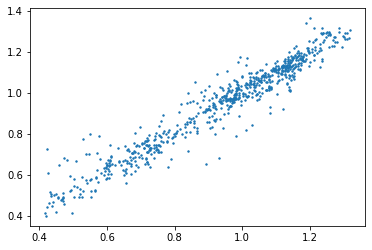

In [ ]:
plt.scatter(y_test, y_pred, s=2)

In [ ]:
mean_squared_error(y_test, y_pred)

0.0033962952323206177